In [238]:
import numpy as np
import random
import string
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [239]:
def generate_counting_dataset(n, T, k, special_char='A', special_value=7, seed=None):
    """
    Génère un dataset de comptage avec traitement spécial pour une lettre (ex: 'A').
    
    Args:
        n: nombre de séquences
        T: longueur de chaque séquence
        k: nombre de lettres (A, B, C, ..., jusqu’à la k-ème)
        special_char: caractère à traiter spécialement (ex: 'A')
        special_value: valeur assignée à ce caractère (ex: 7)
    
    Returns:
        X: [n, T, D] embeddings
        y: [n, T] entiers cibles
        char_to_id, id_to_char: dictionnaires utiles
    """
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    # Dictionnaires et embeddings
    letters = list(string.ascii_uppercase[:k])
    assert special_char in letters, "Le caractère spécial doit être dans l'alphabet"
    char_to_id = {c: i for i, c in enumerate(letters)}
    id_to_char = {i: c for c, i in char_to_id.items()}
    D = len(letters)
    embeddings = np.eye(D)

    X = []
    y = []

    for _ in range(n):
        seq = random.choices(letters, k=T)
        counts = {c: seq.count(c) for c in letters}
        y_seq = [special_value if c == special_char else counts[c] for c in seq]
        x_seq = [embeddings[char_to_id[c]] for c in seq]
        X.append(x_seq)
        y.append(y_seq)

    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long), char_to_id, id_to_char


In [363]:
n = 100000
T = 20
D = 10

In [364]:
X, y, char_to_id, id_to_char = generate_counting_dataset(n=n, T=T, k=D, special_char='A', special_value=7)
print(X.shape)  # torch.Size([1000, 10, 5])
print(y.shape)  # torch.Size([1000, 10])
print()
print("Exemple :", y[0])


torch.Size([100000, 20, 10])
torch.Size([100000, 20])

Exemple : tensor([5, 3, 3, 7, 2, 1, 3, 5, 5, 3, 2, 5, 5, 2, 3, 3, 3, 3, 3, 2])


In [365]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [366]:
X_train[1], y_train[1]

(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1

In [367]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)  # [1, max_len, d_model]

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)].to(x.device)
        return x

In [ ]:
class AttentionOnlyBlock(nn.Module):
    def __init__(self, d_model):
        super(AttentionOnlyBlock, self).__init__()
        self.Wq = nn.Linear(d_model, d_model)
        self.Wk = nn.Linear(d_model, d_model)
        self.Wv = nn.Linear(d_model, d_model)
        self.norm = nn.LayerNorm(d_model)
        self.attn_weights = None

    def forward(self, x):
        Q = self.Wq(x)
        K = Q
        V = self.Wv(x)
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(x.size(-1))
        
        self.attn_weights = attn_scores
        attn_weights = F.softmax(attn_scores, dim=-1)
        x = x + torch.matmul(attn_weights, V)
        x = self.norm(x)
        return x


In [369]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        self.transformer_blocks = nn.ModuleList([AttentionOnlyBlock(d_model) for _ in range(num_layers)])
        # regression
        self.fc = nn.Linear(d_model, 1)
    def forward(self, x):
        x = self.embedding(x)
        x = self.positional_encoding(x)
        for block in self.transformer_blocks:
            x = block(x)
        x = self.fc(x)
        return x

In [370]:
def counting_accuracy(preds, targets):
    """
    Calcule l'accuracy lettre par lettre : proportion de tokens dont le compte prédit (arrondi)
    correspond exactement au compte attendu.

    Args:
        preds: Tensor de forme [B, T], prédictions continues du modèle (après squeeze)
        targets: Tensor de forme [B, T], entiers attendus

    Returns:
        Float : accuracy moyenne sur l'ensemble du batch
    """
    rounded_preds = torch.round(preds).long()
    correct = (rounded_preds == targets).float()
    return correct.mean().item()


In [371]:
def train_model(model, train_loader, test_loader, epochs=10, lr=1e-3, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(1, epochs + 1):
        model.train()
        total_train_loss = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)  # xb: [B, T, D], yb: [B, T]
            preds = model(xb).squeeze(-1)          # [B, T, 1] -> [B, T]
            loss = criterion(preds, yb.float())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        # Validation
        model.eval()
        total_val_loss = 0
        total_acc = 0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb).squeeze(-1)
                acc = counting_accuracy(preds, yb)

                val_loss = criterion(preds, yb.float())
                total_val_loss += val_loss.item()
                # Calcul de l'accuracy
                total_acc += acc

        

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(test_loader)
        avg_acc = total_acc / len(test_loader)

        print(f"Epoch {epoch}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {avg_acc:.4f}")


In [372]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, shuffle=False)

In [373]:
model = TransformerModel(input_dim=D, d_model=256, nhead=1, num_layers=2)

In [374]:
train_model(model, train_loader, test_loader, epochs=20, lr=1e-3, device=device)

Epoch 1/20 | Train Loss: 1.1364 | Val Loss: 0.4436 | Val Acc: 0.4968
Epoch 2/20 | Train Loss: 0.1762 | Val Loss: 0.0980 | Val Acc: 0.9114
Epoch 3/20 | Train Loss: 0.1144 | Val Loss: 0.0946 | Val Acc: 0.9185
Epoch 4/20 | Train Loss: 0.1046 | Val Loss: 0.1105 | Val Acc: 0.8978
Epoch 5/20 | Train Loss: 0.1011 | Val Loss: 0.0858 | Val Acc: 0.9217
Epoch 6/20 | Train Loss: 0.0927 | Val Loss: 0.0799 | Val Acc: 0.9331
Epoch 7/20 | Train Loss: 0.0867 | Val Loss: 0.0966 | Val Acc: 0.9094
Epoch 8/20 | Train Loss: 0.0839 | Val Loss: 0.0710 | Val Acc: 0.9397
Epoch 9/20 | Train Loss: 0.0775 | Val Loss: 0.0640 | Val Acc: 0.9471
Epoch 10/20 | Train Loss: 0.0750 | Val Loss: 0.0650 | Val Acc: 0.9483
Epoch 11/20 | Train Loss: 0.0734 | Val Loss: 0.0794 | Val Acc: 0.9347
Epoch 12/20 | Train Loss: 0.0704 | Val Loss: 0.0776 | Val Acc: 0.9339
Epoch 13/20 | Train Loss: 0.0684 | Val Loss: 0.0654 | Val Acc: 0.9494
Epoch 14/20 | Train Loss: 0.0644 | Val Loss: 0.0595 | Val Acc: 0.9522
Epoch 15/20 | Train Loss: 0.0

In [379]:
def test_model_on_sequence(model, sequence, char_to_id, special_char='A', special_value=7, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Teste le modèle sur une séquence de lettres donnée.
    Affiche la séquence, les cibles attendues et les prédictions du modèle.
    Colore en vert les bons prédits, en rouge les erreurs. Les colonnes sont alignées.
    """
    import numpy as np
    D = len(char_to_id)
    embeddings = np.eye(D)
    
    
    x_seq = [embeddings[char_to_id[c]] for c in sequence]
    x_tensor = torch.tensor([x_seq], dtype=torch.float32).to(device)

    counts = {c: sequence.count(c) for c in char_to_id}
    y_target = [special_value if c == special_char else counts[c] for c in sequence]

    model.eval()
    with torch.no_grad():
        preds = model(x_tensor).squeeze(0).squeeze(-1).cpu().numpy()
        preds_rounded = [round(p) for p in preds]

    print("📝 Input sequence  : ", end="")
    for i, c in enumerate(sequence):
        color = "\033[92m" if preds_rounded[i] == y_target[i] else "\033[91m"
        print(f"{color}{c:>3}\033[0m", end="")  # lettre alignée à droite sur 3 espaces
    print()

    print("🎯 Expected counts : ", end="")
    for i, y in enumerate(y_target):
        color = "\033[92m" if preds_rounded[i] == y else "\033[91m"
        print(f"{color}{y:>3}\033[0m", end="")  # nombre aligné à droite sur 3 espaces
    print()

    print("🔮 Model predicts  : ", end="")
    for i, y in enumerate(preds_rounded):
        color = "\033[92m" if y == y_target[i] else "\033[91m"
        print(f"{color}{y:>3}\033[0m", end="")  # aligné à droite
    print()


In [380]:

def generate_random_letter_sequence(T, D, seed=None):
    """
    Génère une séquence de T lettres aléatoires parmi les D premières lettres majuscules.
    """
    assert D <= 26, "D ne peut pas dépasser 26 (nombre de lettres majuscules)."
    if seed is not None:
        random.seed(seed)
    alphabet = list(string.ascii_uppercase[:D])
    sequence = random.choices(alphabet, k=T)
    return sequence

In [381]:
number_of_sequences = 10
for i in range(number_of_sequences):
    sequence = generate_random_letter_sequence(T, D)
    print(f"Sequence {i+1}: {''.join(sequence)}_______________")
    test_model_on_sequence(model, sequence, char_to_id, special_char='A', special_value=7, device=device)



Sequence 1: GDHBCIEIGIAIHJDCHAFE_______________
📝 Input sequence  :   G  D  H  B  C  I  E  I  G  I  A  I  H  J  D  C  H  A  F  E
🎯 Expected counts :   2  2  3  1  2  4  2  4  2  4  7  4  3  1  2  2  3  7  1  2
🔮 Model predicts  :   2  2  3  1  2  4  2  4  2  4  7  4  3  1  2  2  3  7  1  2
Sequence 2: GCHBEDBGICIFGAIDDAIG_______________
📝 Input sequence  :   G  C  H  B  E  D  B  G  I  C  I  F  G  A  I  D  D  A  I  G
🎯 Expected counts :   4  2  1  2  1  3  2  4  4  2  4  1  4  7  4  3  3  7  4  4
🔮 Model predicts  :   4  2  1  2  1  3  2  4  4  2  4  1  4  7  4  3  3  7  4  4
Sequence 3: JHAAIACGIGBIDEGHHGFI_______________
📝 Input sequence  :   J  H  A  A  I  A  C  G  I  G  B  I  D  E  G  H  H  G  F  I
🎯 Expected counts :   1  3  7  7  4  7  1  4  4  4  1  4  1  1  4  3  3  4  1  4
🔮 Model predicts  :   1  3  7  7  4  7  1  4  4  4  1  4  1  1  4  3  3  4  1  4
Sequence 4: EIHBIHAIJGICBGBCICEJ_______________
📝 Input sequence  :   E  I  H  B  I  H  A  I  J  G  I  C  B  G  B  C  I  C  E  

In [393]:
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np

def compute_sequence_accuracy(preds, targets):
    preds_rounded = torch.round(preds).long()
    correct = (preds_rounded == targets).sum().item()
    return correct / len(targets)

def plot_attention_matrices_with_accuracy(model, sequences, char_to_id, special_char='A', special_value=7, device='cuda' if torch.cuda.is_available() else 'cpu'):
    D = len(char_to_id)
    embeddings = np.eye(D)
    model.eval()

    num_sequences = len(sequences)
    fig, axs = plt.subplots(num_sequences, 2, figsize=(14, 3.5 * num_sequences))

    if num_sequences == 1:
        axs = [axs]

    for i, sequence in enumerate(sequences):
        # Embedding + entrée
        x_seq = [embeddings[char_to_id[c]] for c in sequence]
        x_tensor = torch.tensor([x_seq], dtype=torch.float32).to(device)

        # Calcul des cibles attendues
        counts = {c: sequence.count(c) for c in char_to_id}
        y_target = torch.tensor([[special_value if c == special_char else counts[c] for c in sequence]], dtype=torch.long).to(device)

        # Prédiction
        with torch.no_grad():
            preds = model(x_tensor).squeeze(0)  # [T, 1]
        acc = compute_sequence_accuracy(preds.squeeze(-1), y_target.squeeze(0))

        # Matrices d’attention
        attn0 = F.softmax(model.transformer_blocks[0].attn_weights, dim=-1).detach().squeeze(0).cpu().numpy()
        attn1 = F.softmax(model.transformer_blocks[1].attn_weights, dim=-1).detach().squeeze(0).cpu().numpy()

        # Heatmap Layer 0
        sns.heatmap(attn0, cmap="viridis", xticklabels=sequence, yticklabels=sequence, square=True,
                    cbar=True, ax=axs[i][0])
        axs[i][0].set_title(f"Layer 0 – Seq {i+1} – Acc: {acc:.2f}")
        axs[i][0].set_xlabel("Attended Tokens")
        axs[i][0].set_ylabel("Attending Tokens")
        axs[i][0].tick_params(axis='x', rotation=90)

        # Heatmap Layer 1
        sns.heatmap(attn1, cmap="viridis", xticklabels=sequence, yticklabels=sequence, square=True,
                    cbar=True, ax=axs[i][1])
        axs[i][1].set_title(f"Layer 1 – Seq {i+1} – Acc: {acc:.2f}")
        axs[i][1].set_xlabel("Attended Tokens")
        axs[i][1].set_ylabel("Attending Tokens")
        axs[i][1].tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()


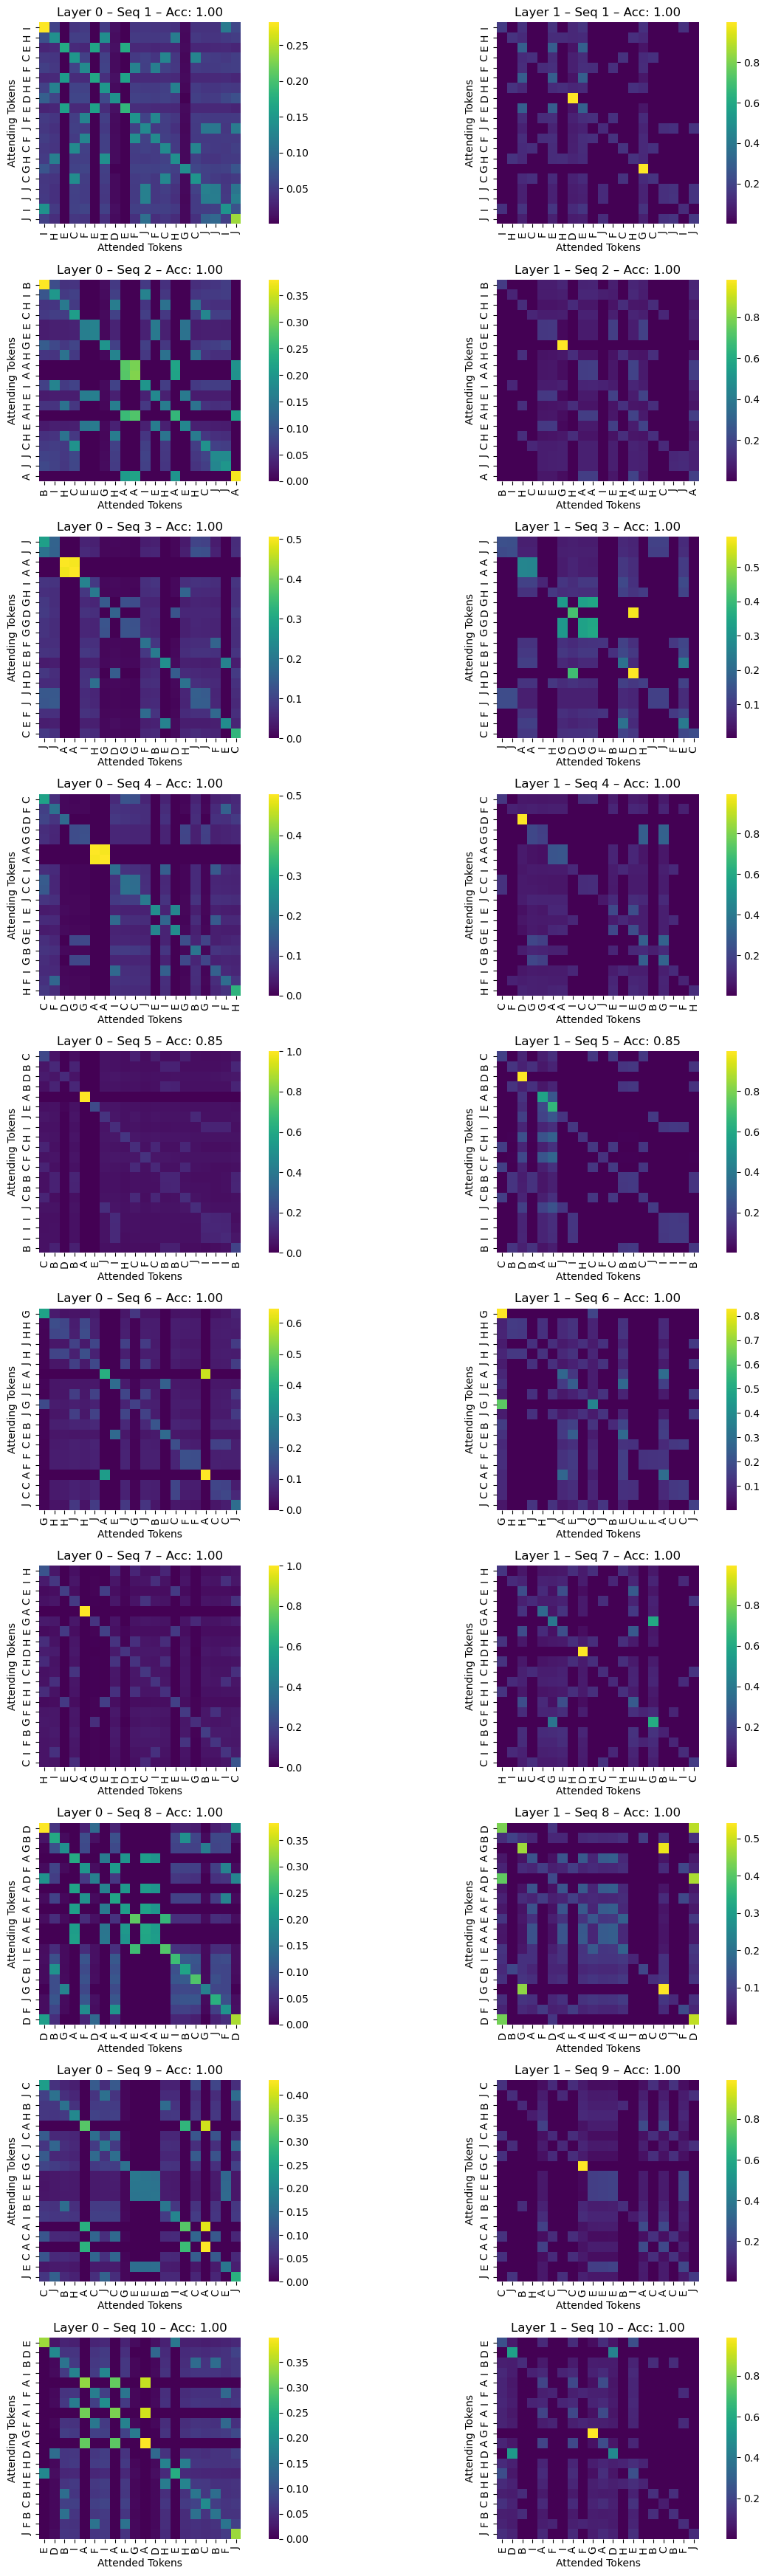

In [394]:
sequences = [generate_random_letter_sequence(T, D, seed=i) for i in range(10)]
plot_attention_matrices_with_accuracy(model, sequences, char_to_id, special_char='A', special_value=7, device=device)

In [387]:
fig.savefig("images/attention_matrix.png", dpi=300)